In [1]:
import os
import sys
import batman
import numpy as np
from astropy.io import fits
from astropy import units
import matplotlib.pyplot as plt
from astropy.time import Time
from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2
from cos_transits import TransitsWithCOS

In [2]:
url = 'https://coolors.co/palette/0d47a1-1565c0-1976d2-1e88e5-2196f3-42a5f5-64b5f6-90caf9-bbdefb'
url = 'https://coolors.co/102f4d-0e385e-074d87-0061b0-0f75cb-1e88e5-2196f3-6ebaf7-95ccf9-bbdefb'
colors = np.array(['#{0}'.format(i) for i in url.split('/')[-1].split('-')])

# data set up

Predicted transit times from Wittrock's TTV model (units of MJD)

In [3]:
midpoint_1 = np.array([2459362.86254, 2459362.87127, 2459362.86697, 
                       2459362.86884, 2459362.89635, 2459362.86595])
unc_1 = np.array([0.04072, 0.0837, 0.04114, 0.11863, 0.04571, 0.04543])

midpoint_2 = np.array([2459481.34356, 2459481.35327, 2459481.34841, 
                       2459481.35000, 2459481.38073, 2459481.34711])
unc_2 = np.array([0.04094, 0.08504, 0.04142, 0.11864, 0.04611, 0.04557])

midpoint_3 = np.array([2459862.17541, 2459862.18827, 2459862.18161, 
                       2459862.18230, 2459862.22338, 2459862.17941])
unc_3 = np.array([0.04178, 0.09013, 0.04251, 0.11864, 0.04763, 0.04613])

In [4]:
def prop_error(vals):
    err = np.sqrt(np.nansum((vals-np.nanmean(vals))**2)/(len(vals)-1))
    return err

In [5]:
predicted_Tc = np.array([np.nanmean(midpoint_1), np.nanmean(midpoint_2), np.nanmean(midpoint_3)])-2400000.5
predicted_Tc_err = np.array([prop_error(midpoint_1), prop_error(midpoint_2),
                             prop_error(midpoint_3)])

dur = 3.4927
predicted_ingress = predicted_Tc - ((dur/2)*units.hour).to(units.day).value
predicted_egress  = predicted_Tc + ((dur/2)*units.hour).to(units.day).value

In [6]:
data_a = np.load('AU_Mic/data_a_30s_wavecorr.npy', allow_pickle=True).item()
data_b = np.load('AU_Mic/data_b_30s_wavecorr.npy', allow_pickle=True).item()
fmask = np.load('aumic_flare_mask.npy')

In [7]:
visits = np.zeros(len(data_a['time']))
inds = np.where(np.diff(data_a['time']) > 1)[0]+1
inds = np.sort(np.append([0, len(data_a['time'])], inds))
for i in range(len(inds)-1):
    visits[inds[i]:inds[i+1]] = i+1

In [8]:
twc_a = TransitsWithCOS(data_a['wavelength'], 
                        data_a['flux'], 
                        data_a['flux_err'],
                        data_a['time'], 
                        predicted_Tc, predicted_ingress, 
                        predicted_egress, interpolate=True)

twc_b = TransitsWithCOS(data_b['wavelength'], 
                        data_b['flux'], 
                        data_b['flux_err'],
                        data_b['time'], 
                        predicted_Tc, predicted_ingress, 
                        predicted_egress, interpolate=True)

In [11]:
twc_a.define_in_vs_out(inbounds=[-0.06, 0.06], outbounds=[-0.24, -0.14])
twc_a.load_line_table('.', 'aumic_linelist.txt')

twc_b.define_in_vs_out(inbounds=[-0.06, 0.06], outbounds=[-0.24, -0.14])
twc_b.load_line_table('.', 'aumic_linelist.txt')

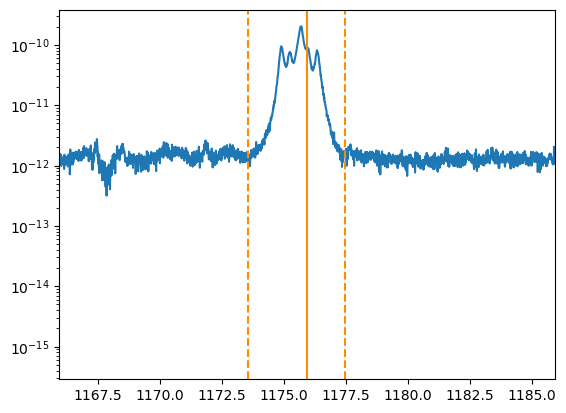

In [13]:
plt.plot(twc_b.wavelength[0], np.nansum(twc_b.flux[:-232],axis=0))
plt.yscale('log')
ion = 1175.95 
plt.xlim(ion-10, ion+10)
plt.axvline(ion, color='darkorange')
plt.axvline(ion-2.4, color='darkorange', linestyle='--')
plt.axvline(ion+1.5, color='darkorange', linestyle='--')

## Flare mask

In [ ]:
for i in range(1,16):
    q = twc_a.orbits[0] == i
    w = (twc_a.wavelength[q][0] >= 1294.55-1) & (twc_a.wavelength[q][0] <= 1294.55+0.6)
    plt.plot(twc_a.time[q],
             np.nansum(twc_a.flux[:,w], axis=1)[q]/np.nanmedian(np.nansum(twc_a.flux[:,w], axis=1)[q]))
    
    q = twc_b.orbits[0] == i
    w = (twc_b.wavelength[q][0] >= 1175.95 - 2.4) & (twc_b.wavelength[q][0] <= 1175.95 + 1.5)
    plt.plot(twc_b.time[q],
             np.nansum(twc_b.flux[:,w], axis=1)[q]/np.nanmedian(np.nansum(twc_b.flux[:,w], axis=1)[q]))

    plt.vlines(ftimes[2], 0,2, color='k', zorder=0)
    
    plt.xlim(twc_b.time[q].min(), twc_b.time[q].max())
    plt.title(i)
    plt.show()

In [ ]:
ftimes = np.array([[1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3],
                   [2, 3, 4, 4, 5, 5, 6, 9, 10, 10, 10, 10, 10, 13, 13, 14, 14, 14, 15, 11],
                   [59362.216335641104, 59362.28507378111, 
                    59362.34362378111, 59362.34992378111,
                    59362.41207378112, 59362.42217378112,
                    59480.63960269112, 59480.82794195112,
                    59480.892122321115, 59480.895322321114,
                    59480.89652232112, 59480.898422321116, 
                    59480.901322321115, 59861.65808900111,
                    59861.66368900111, 59861.72188826111,
                    59861.72623826111, 59861.73408826111,
                    59861.80032270112, 59861.53640261]
                 ])

In [ ]:
fmask = np.zeros(len(twc_a.time))

for i in range(len(ftimes[0])):
    plt.plot(twc_a.time, np.nansum(twc_a.flux, axis=1), color='k')
    if i == 1:
        x1, x2 = 0.0008, 0.006
    elif i == 16:
        x1, x2 = 0.0009, 0.002
    else:
        x1, x2 = 0.0005, 0.0007
    plt.axvspan(ftimes[2][i]-x1, ftimes[2][i]+x2, alpha=0.4, color='darkorange', lw=0)
    plt.xlim(ftimes[2][i]-0.01, ftimes[2][i]+0.01)
    
    ind = np.where((twc_a.time>=ftimes[2][i]-x1) &
                   (twc_a.time<=ftimes[2][i]+x2))[0]
    fmask[ind] = 1
    
    plt.title(i)
    plt.show()

In [ ]:
np.save('aumic_flare_mask.npy', fmask)

# Light Curves

In [14]:
%load_ext autoreload
%autoreload 2
from cos_transits import TransitsWithCOS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


16.86746987951807


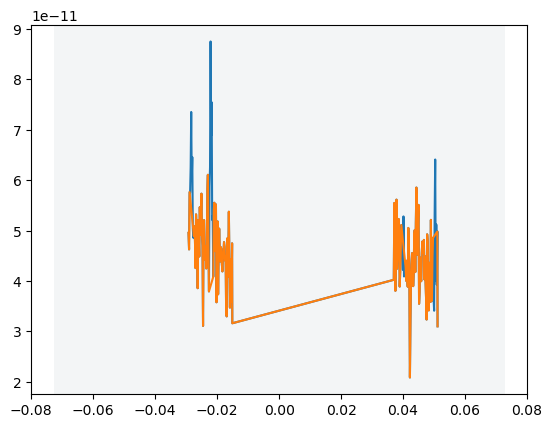

25.301204819277118


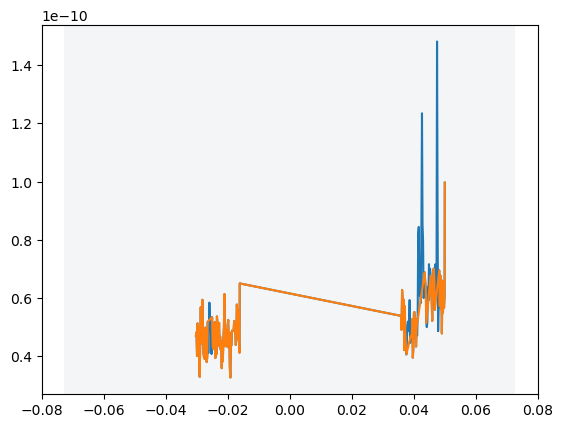

27.108433734939766


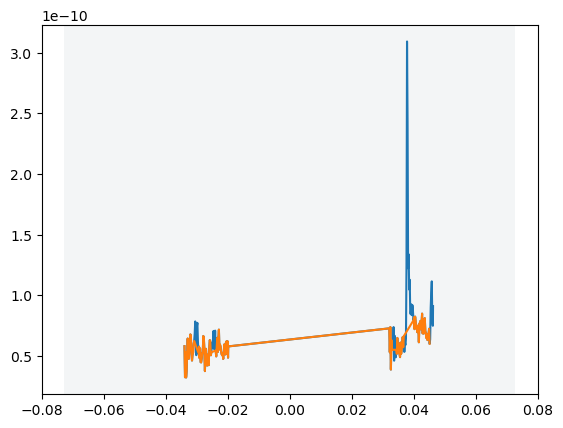

In [15]:
for v in range(1,4):
    q = (twc_b.visits==v) & (twc_b.phases[v-1]>-0.07) & (twc_b.phases[v-1]<0.07)
    
    plt.plot(twc_b.phases[v-1][q], np.nansum(twc_b.flux[q], axis=1))

    qq = fmask[q] == 0

    plt.plot(twc_b.phases[v-1][q][qq], np.nansum(twc_b.flux[q][qq], axis=1))
    
    len1 = len(np.nansum(twc_b.flux[q], axis=1))
    len2 = len(np.nansum(twc_b.flux[q][qq], axis=1))
    print(100-(len2/len1)*100)
    
    plt.axvspan(predicted_ingress[v-1]-predicted_Tc[v-1],
                predicted_egress[v-1]-predicted_Tc[v-1], 
                color='#e9ecef', lw=0, alpha=0.5, zorder=0)
    plt.show()

18.159203980099505


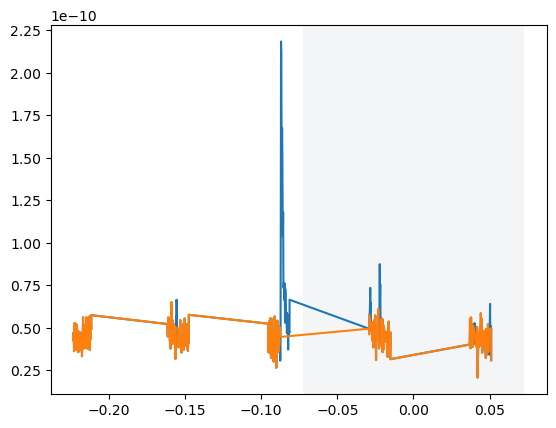

12.189054726368155


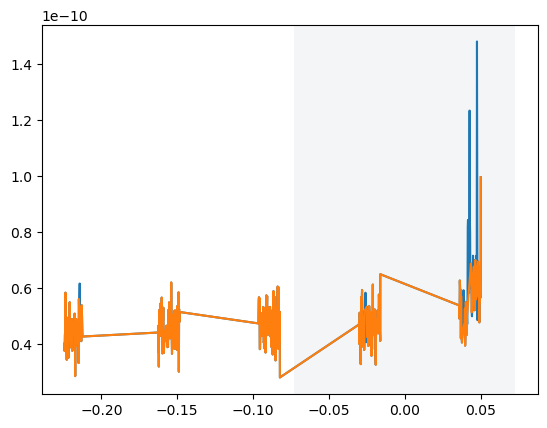

14.536340852130323


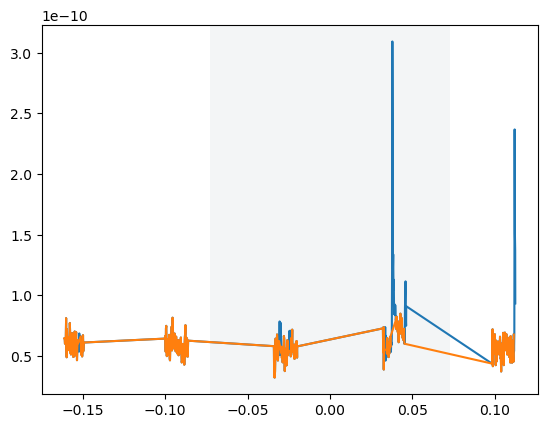

In [163]:
for v in range(1,4):
    q = twc_b.visits==v
    
    plt.plot(twc_b.phases[v-1][q], np.nansum(twc_b.flux[q], axis=1))

    qq = fmask[q] == 0

    plt.plot(twc_b.phases[v-1][q][qq], np.nansum(twc_b.flux[q][qq], axis=1))
    
    len1 = len(np.nansum(twc_b.flux[q], axis=1))
    len2 = len(np.nansum(twc_b.flux[q][qq], axis=1))
    print(100-(len2/len1)*100)
    
    plt.axvspan(predicted_ingress[v-1]-predicted_Tc[v-1],
                predicted_egress[v-1]-predicted_Tc[v-1], 
                color='#e9ecef', lw=0, alpha=0.5, zorder=0)
    plt.show()

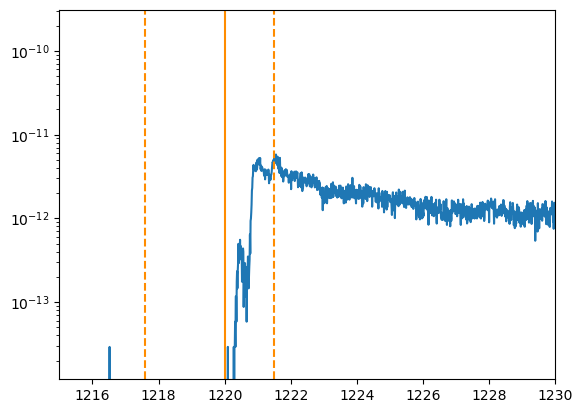

In [28]:
plt.plot(twc_a.wavelength[0], np.nansum(twc_a.flux[:400],axis=0))
plt.yscale('log')
ion = 1220
plt.xlim(ion-5, ion+10)
plt.axvline(ion, color='darkorange')
plt.axvline(ion-2.4, color='darkorange', linestyle='--')
plt.axvline(ion+1.5, color='darkorange', linestyle='--')

Text(0.5, 0, 'Transit Phase')

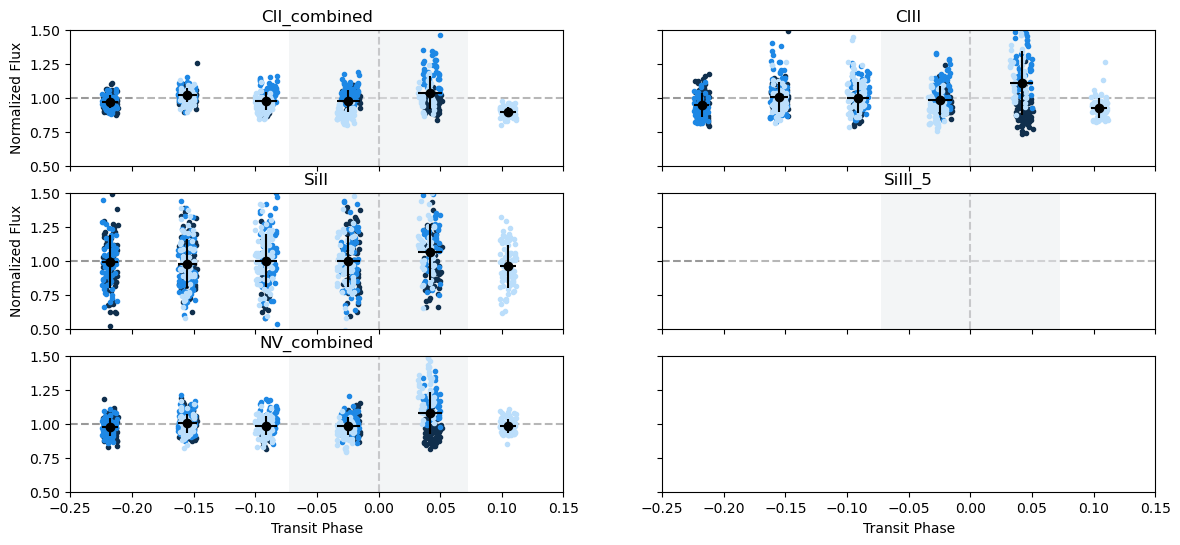

In [17]:
ions = ['CII_combined', 'CIII', 'SiII', 'SiIII_5',  'NV_combined']


fig, axes = plt.subplots(figsize=(14,6), ncols=2, nrows=int(len(ions)/2)+1, 
                         sharex=True, sharey=True)
fig.set_facecolor('w')
axes = axes.reshape(-1)

visits = [1,2,3]

for i in range(len(ions)):
    
    wave_c = twc_a.line_table[twc_a.line_table['ion']==ions[i]]['wave_c']
    
    if (wave_c >= twc_a.wavelength[0][0]) & (wave_c <= twc_a.wavelength[0][-1]):
        
        tab_temp, avg_temp = twc_a.plot_lc(ion=ions[i], 
                                           colors=colors[np.array([0, 5, -1], dtype=int)],
                                           ax=axes[i], detrend=True, 
                                           visits=visits, mask=fmask,
                                           pldict={'marker':'.', 'linestyle':'', 'zorder':1,
                                                   'rasterized':True})
    else:
        tab_temp, avg_temp = twc_b.plot_lc(ion=ions[i], 
                                           colors=colors[np.array([0, 5, -1], dtype=int)],
                                           ax=axes[i], detrend=True, 
                                           visits=visits, mask=fmask,
                                           pldict={'marker':'.', 'linestyle':'', 'zorder':1,
                                                   'rasterized':True})
    
    if i == 0:
        all_lcs = tab_temp
        avg_lcs = avg_temp
        
    else:
        for colname in tab_temp.colnames:
            all_lcs[colname] = tab_temp[colname]
        for colname in avg_temp.colnames:
            avg_lcs[colname] = avg_temp[colname]
    
        
    axes[i].set_title(ions[i])
    axes[i].axhline(1, color='k', linestyle='--', alpha=0.4, zorder=0)
    axes[i].axvline(0, color='k', linestyle='--', alpha=0.5, zorder=0)

    axes[i].axvspan(-0.2, 0.35, zorder=0,
                    color='#ffffff', lw=0, alpha=0.3)

    axes[i].axvspan(predicted_ingress[2]-predicted_Tc[2],
                    predicted_egress[2]-predicted_Tc[2], 
                    color='#e9ecef', lw=0, alpha=0.5, zorder=0)

plt.xlim(-0.25, 0.15)
plt.ylim(0.5, 1.5)
for i in [0, 2]:
    axes[i].set_ylabel('Normalized Flux')
axes[-2].set_xlabel('Transit Phase')
axes[-1].set_xlabel('Transit Phase')
#plt.savefig('aumicb_lightcurves.png', dpi=300, 
#            bbox_inches='tight')

In [165]:
for ion in ions:
    print(ion, twc_a.line_table[twc_a.line_table['ion']==ion]['wave_c'][0])

CII_combined 1335.0
CIII 1175.59
SiII_20 1259.521
SiII 1264.738
SiIII 1294.548
SiIII_3 1298.894
NV_combined 1241.0


### BATMAN transit fit

In [121]:
def fit_transit(t, rp):
    params = batman.TransitParams()
    params.t0 = 0.                       #time of inferior conjunction
    params.per = 8.46308                 #orbital period
    params.rp = rp                       #planet radius (in units of stellar radii)
    params.a = 18.79                     #semi-major axis (in units of stellar radii)
    params.inc = 87.                     #orbital inclination (in degrees)
    params.ecc = 0.                      #eccentricity
    params.w = 90.                       #longitude of periastron (in degrees)
    params.u = [0.1, 0.3]                #limb darkening coefficients [u1, u2]
    params.limb_dark = "quadratic"       #limb darkening model
    
    m = batman.TransitModel(params, t)    #initializes model
    flux = m.light_curve(params)          #calculates light curve
    return flux

### Best-fit upper limits

In [122]:
rstar = 0.75

CII_combined 1.9826413279307664 jupiterRad


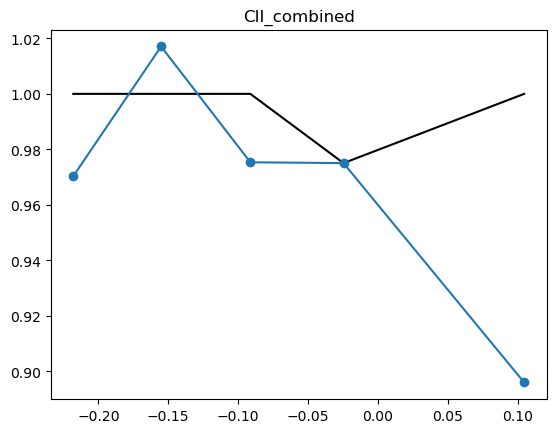

CIII 1.7127748505193074 jupiterRad


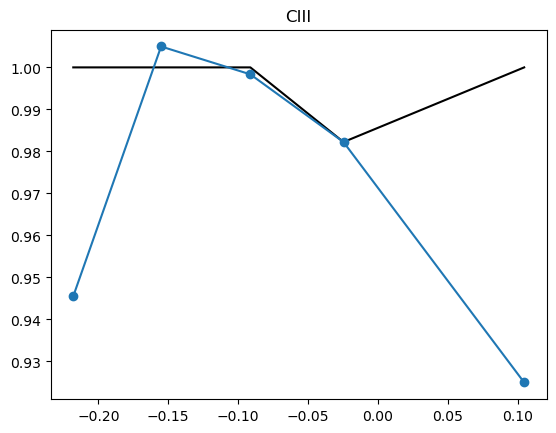

SiII_20 -1.4312904779646576 jupiterRad


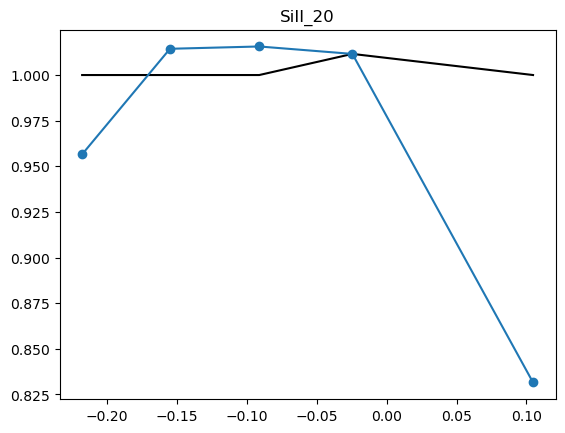

SiII 1.0736686897910503 jupiterRad


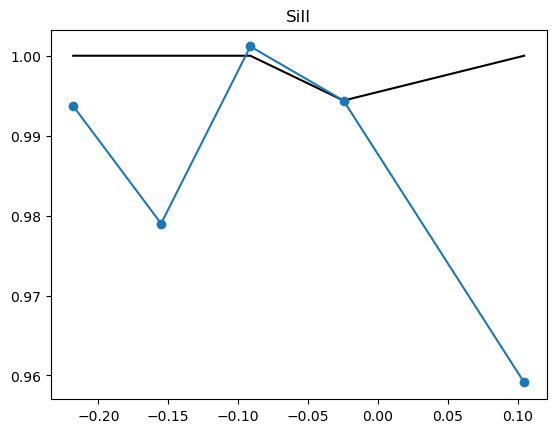

SiIII 2.5412023169167997 jupiterRad


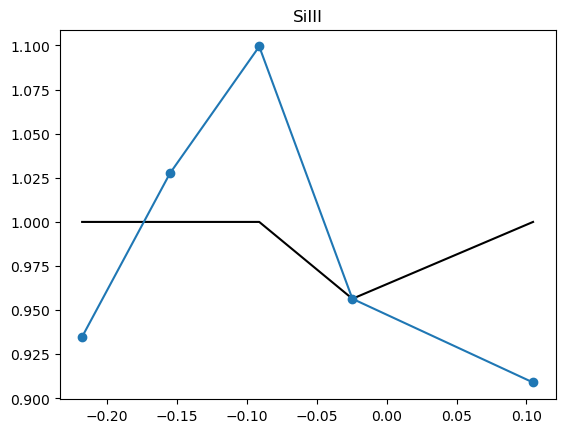

SiIII_3 2.8834777625422037 jupiterRad


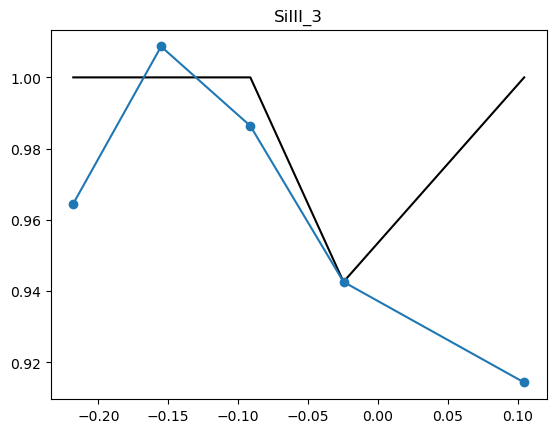

In [188]:
inds = np.array([0,1,2,3,5],dtype=int)

for ion in ions[:-1]:
    res = curve_fit(fit_transit, 
                    avg_lcs['{0}_phase'.format(ion)][inds],
                    avg_lcs['{0}_flux'.format(ion)][inds],#-0.02,
                    p0=[0.1])

    bt = fit_transit(avg_lcs['{0}_phase'.format(ion)][inds], res[0][0])
    
    plt.plot(avg_lcs['{0}_phase'.format(ion)][inds], bt, 'k')

    plt.errorbar(avg_lcs['{0}_phase'.format(ion)][inds],
                 avg_lcs['{0}_flux'.format(ion)][inds],#-0.02,
                 #avg_lcs['{0}_flux_err'.format(ion)], 
                 marker='o')
    plt.title(ion)
    
    print(ion, (rstar*res[0][0]*units.Rsun).to(units.Rjup))
    plt.show()

In [191]:
avg_lcs.write('aumicb_avg_lc_wflares.csv', format='csv', overwrite=True)
all_lcs.write('aumicb_all_lcs_wflares.csv', format='csv', overwrite=True)

In [189]:
avg_lcs.write('aumicb_avg_lc.csv', format='csv', overwrite=True)
all_lcs.write('aumicb_all_lcs.csv', format='csv', overwrite=True)